In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')


In [2]:
train_df = pd.read_csv('/Users/coco/Desktop/專案/loan/playground-series-s4e10/train.csv')
test_df = pd.read_csv('/Users/coco/Desktop/專案/loan/playground-series-s4e10/test.csv')

訓練集缺失值：
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

測試集缺失值：
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

目標變量分佈：
loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64


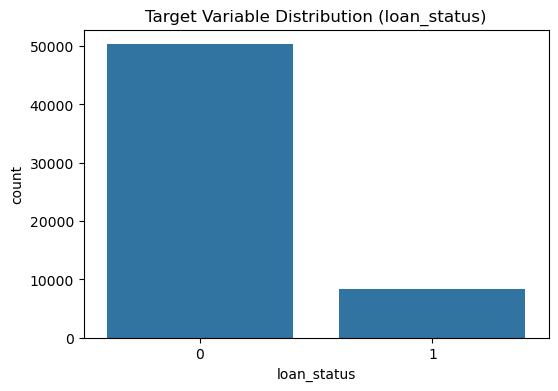

In [3]:
# 檢查缺失值
print("訓練集缺失值：")
print(train_df.isnull().sum())
print("\n測試集缺失值：")
print(test_df.isnull().sum())

# 檢查目標變量分佈
print("\n目標變量分佈：")
print(train_df['loan_status'].value_counts(normalize=True))

# 繪製目標變量分佈圖
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=train_df)
plt.title('Target Variable Distribution (loan_status)')
plt.show()

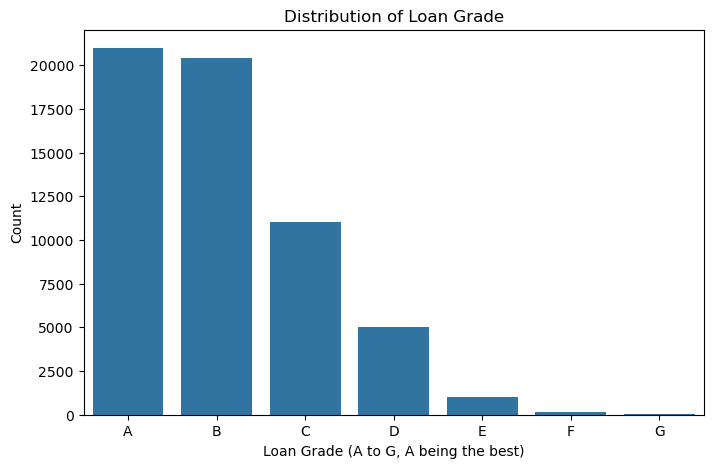

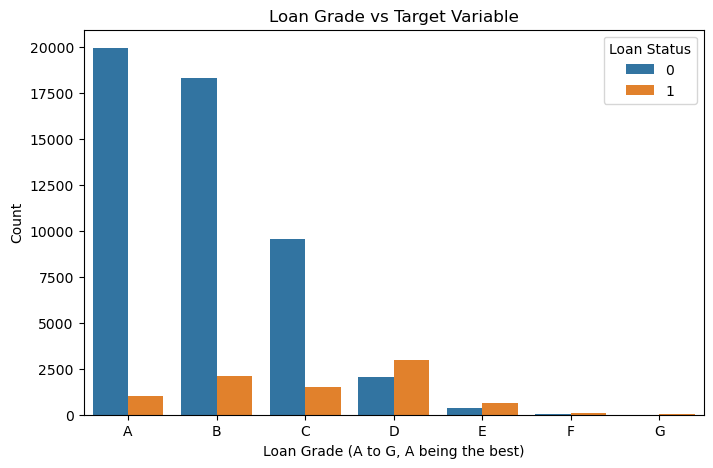

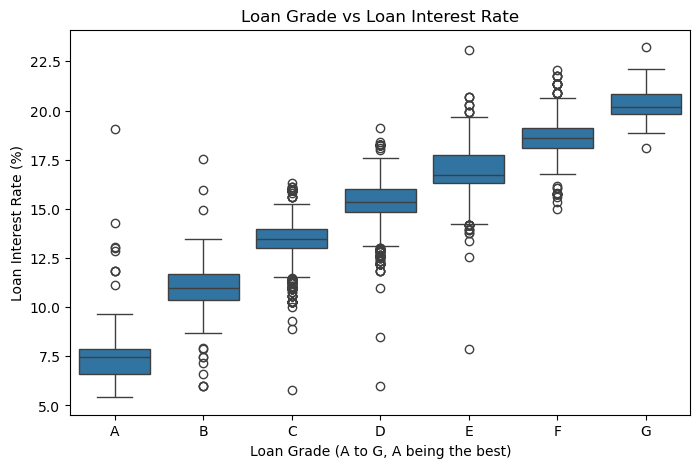

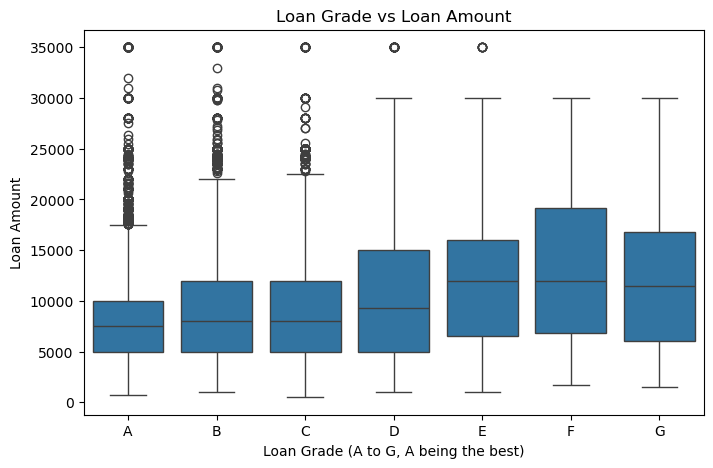

In [4]:
# Loan Grade 分佈
plt.figure(figsize=(8, 5))
sns.countplot(x='loan_grade', data=train_df, order=sorted(train_df['loan_grade'].unique()))
plt.title('Distribution of Loan Grade')
plt.xlabel('Loan Grade (A to G, A being the best)')
plt.ylabel('Count')
plt.show()

# Loan Grade 與 loan_status 的關係
plt.figure(figsize=(8, 5))
sns.countplot(x='loan_grade', hue='loan_status', data=train_df, order=sorted(train_df['loan_grade'].unique()))
plt.title('Loan Grade vs Target Variable')
plt.xlabel('Loan Grade (A to G, A being the best)')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

# Loan Grade 與 loan_int_rate 的關係（假設利率與風險等級相關）
plt.figure(figsize=(8, 5))
sns.boxplot(x='loan_grade', y='loan_int_rate', data=train_df, order=sorted(train_df['loan_grade'].unique()))
plt.title('Loan Grade vs Loan Interest Rate')
plt.xlabel('Loan Grade (A to G, A being the best)')
plt.ylabel('Loan Interest Rate (%)')
plt.show()

# Loan Grade 與 loan_amnt 的關係
plt.figure(figsize=(8, 5))
sns.boxplot(x='loan_grade', y='loan_amnt', data=train_df, order=sorted(train_df['loan_grade'].unique()))
plt.title('Loan Grade vs Loan Amount')
plt.xlabel('Loan Grade (A to G, A being the best)')
plt.ylabel('Loan Amount')
plt.show()

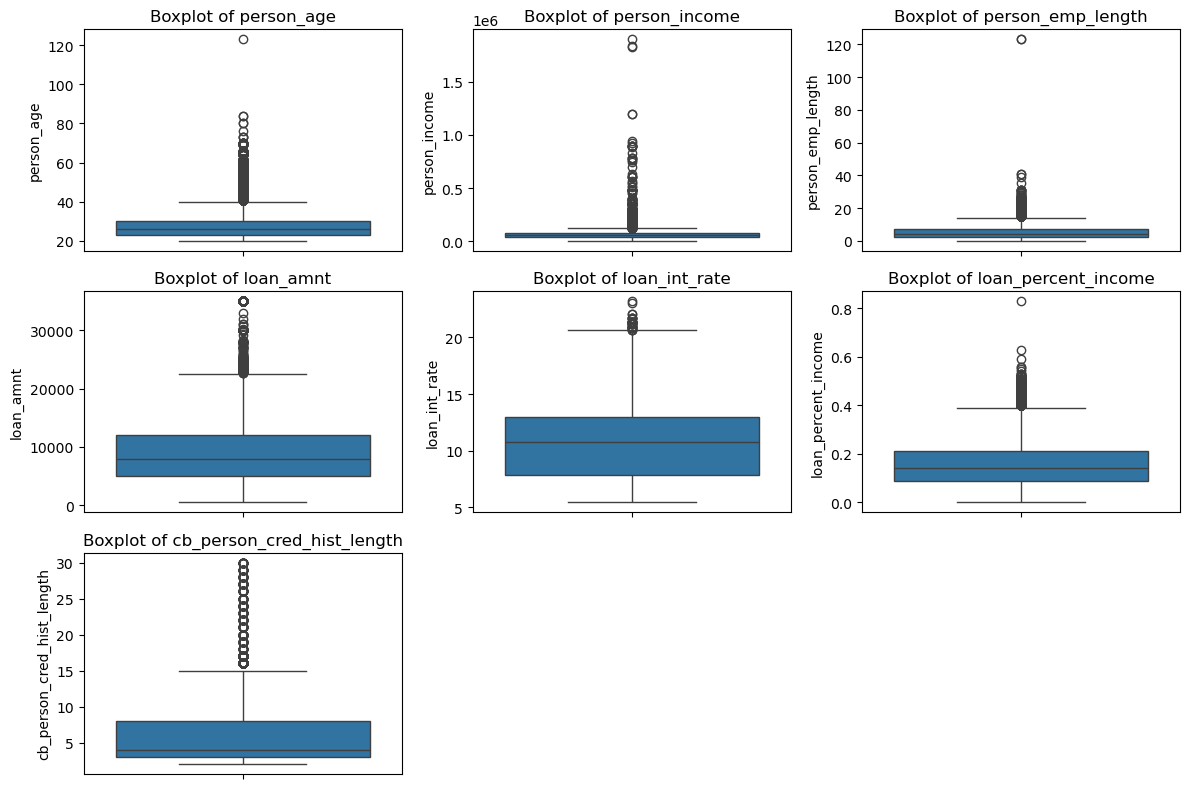

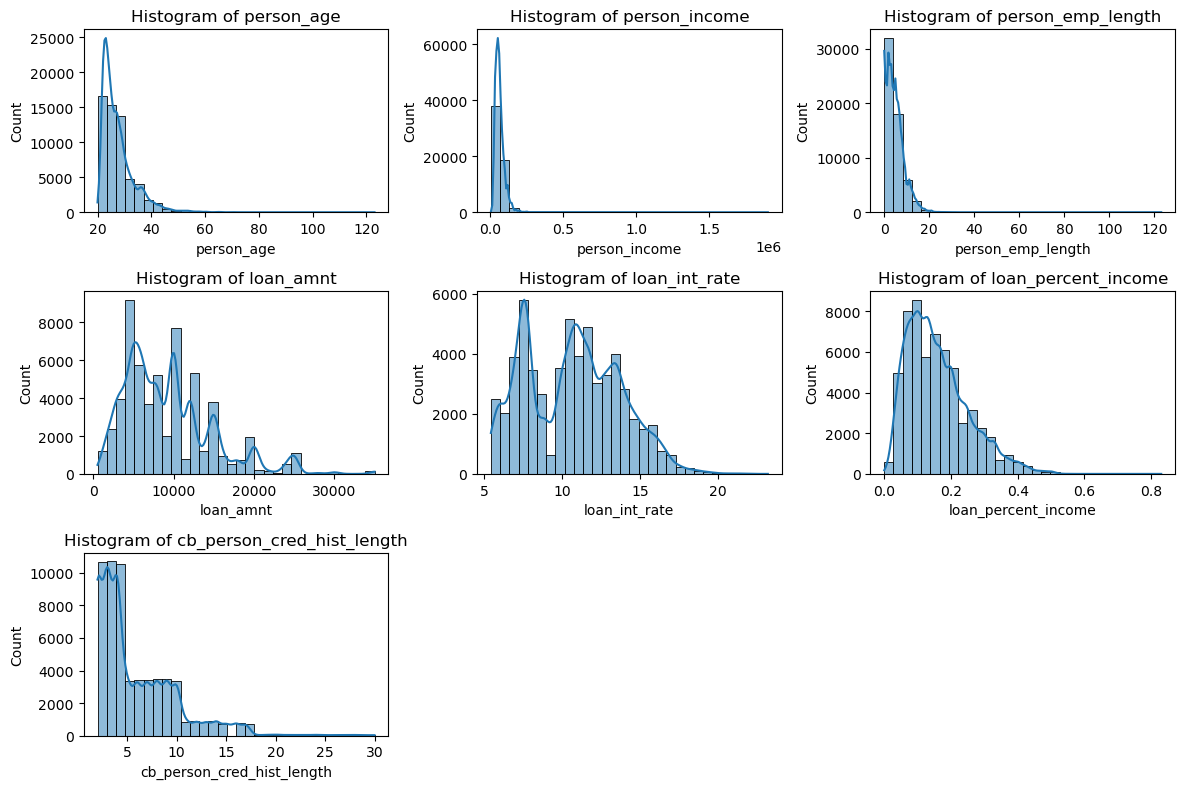

In [5]:
numeric_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
                'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

# 繪製數值型特徵的箱型圖
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=train_df[col])
    plt.title(f'Boxplot of {col}')  
plt.tight_layout()
plt.show()

# 繪製數值型特徵的直方圖,顯示特徵的分佈是否偏態
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

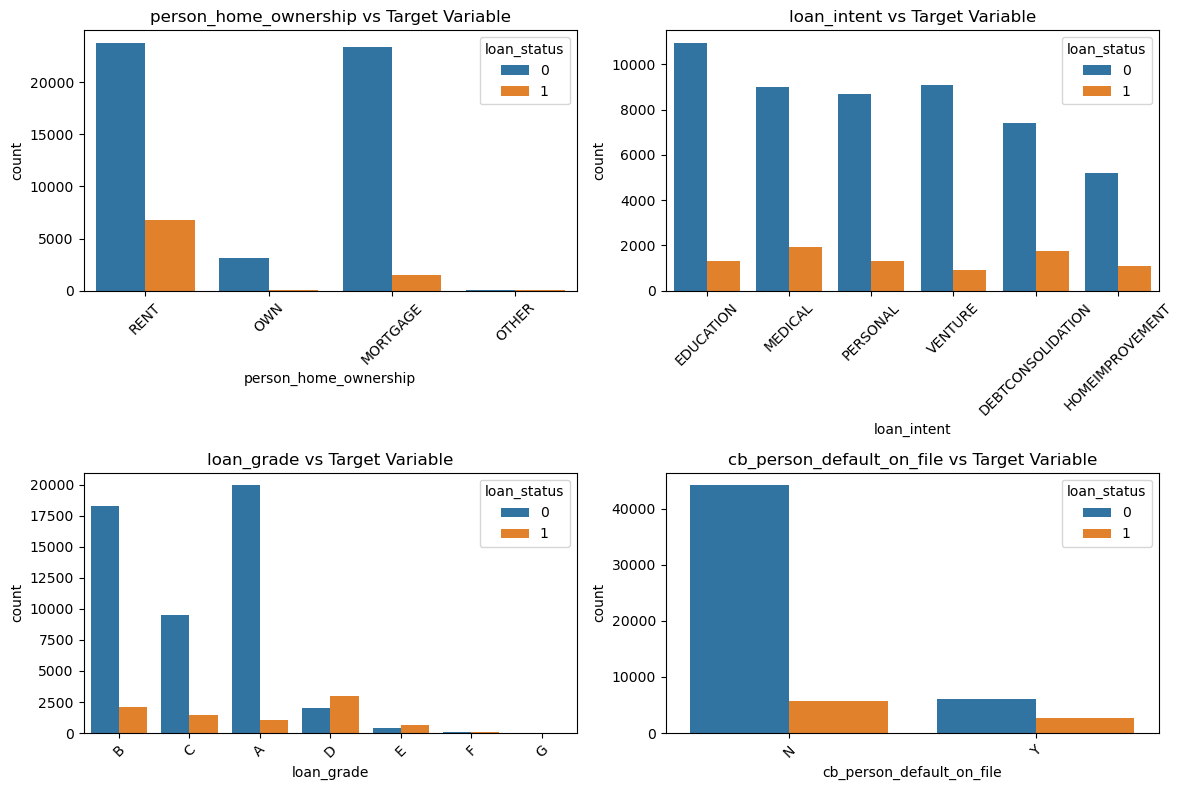

In [6]:
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# 繪製類別型特徵與目標變量的關係
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, hue='loan_status', data=train_df)
    plt.title(f'{col} vs Target Variable')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

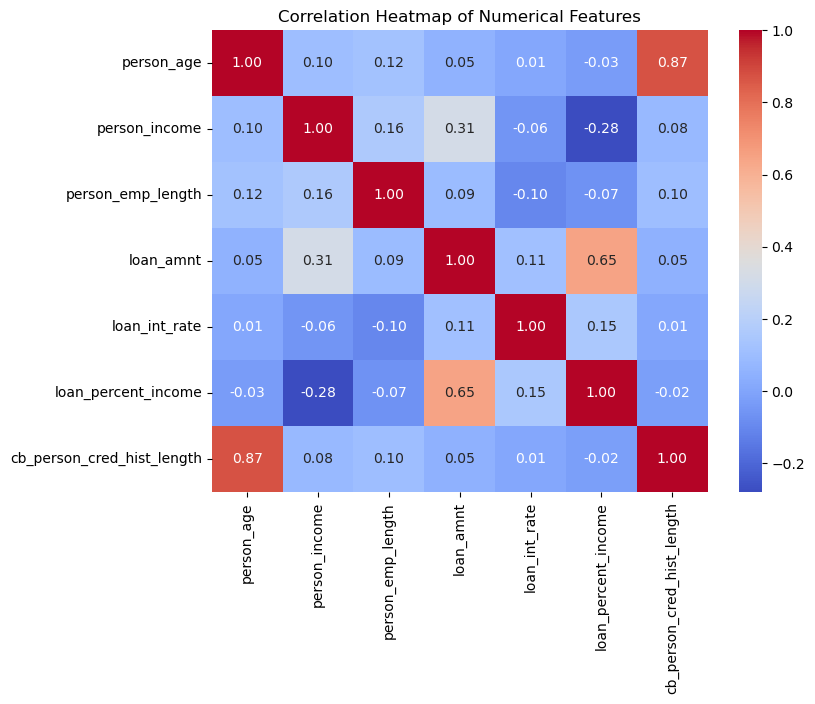

In [7]:
# 計算相關性矩陣
corr_matrix = train_df[numeric_cols].corr()

# 繪製熱力圖
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

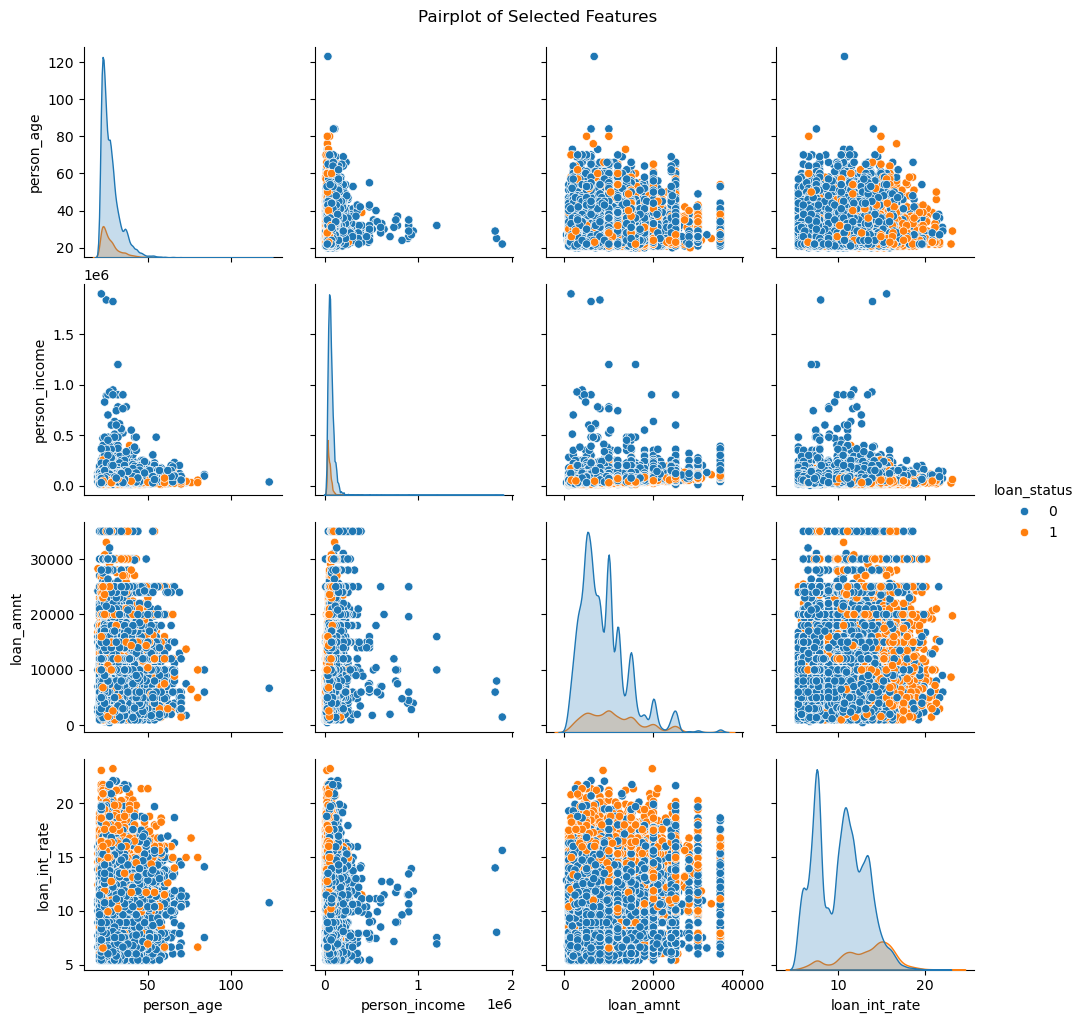

In [8]:
# 選擇部分特徵進行 Pairplot
pairplot_cols = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_status']
sns.pairplot(train_df[pairplot_cols], hue='loan_status', diag_kind='kde')
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

In [9]:
# 對 loan_grade 使用 Label Encoding (有排序)
label_encoder = LabelEncoder()
train_df['loan_grade'] = label_encoder.fit_transform(train_df['loan_grade'])
test_df['loan_grade'] = label_encoder.transform(test_df['loan_grade'])

# 對其他類別型欄位使用 One-Hot Encoding
train_df = pd.get_dummies(train_df, columns=['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'], drop_first=True)

# 確保測試集和訓練集的欄位一致
test_df = test_df.reindex(columns=train_df.columns.drop('loan_status'), fill_value=0)

In [10]:
# 貸款金額與收入的比值
train_df['loan_to_income_ratio'] = train_df['loan_amnt'] / train_df['person_income']
test_df['loan_to_income_ratio'] = test_df['loan_amnt'] / test_df['person_income']

# 工作年限與信用記錄長度的比值
train_df['emp_to_cred_hist_ratio'] = train_df['person_emp_length'] / (train_df['cb_person_cred_hist_length'] + 1)
test_df['emp_to_cred_hist_ratio'] = test_df['person_emp_length'] / (test_df['cb_person_cred_hist_length'] + 1)

In [11]:
# 限制年齡範圍在 18-100 歲
train_df['person_age'] = train_df['person_age'].clip(18, 100)
test_df['person_age'] = test_df['person_age'].clip(18, 100)

# 限制工作年限（不為負）
train_df['person_emp_length'] = train_df['person_emp_length'].clip(lower=0)
test_df['person_emp_length'] = test_df['person_emp_length'].clip(lower=0)

In [12]:
# 對數值型特徵進行標準化
numeric_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
                'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 
                'loan_to_income_ratio', 'emp_to_cred_hist_ratio']

scaler = StandardScaler()
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

In [13]:
# 移除不需要的欄位(id)
train_df = train_df.drop(columns=['id'])
test_ids = test_df['id']
test_df = test_df.drop(columns=['id'])

# 分割特徵和目標變量
X = train_df.drop(columns=['loan_status'])
y = train_df['loan_status']

In [14]:
# 使用 StratifiedKFold 進行 5 折交叉驗證，並計算 ROC-AUC 分數作為評估指標。
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
# 使用 BayesianOptimization 來優化 XGBoost 的超參數。
# 定義 XGBoost 評估函數
def xgb_evaluate(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'min_child_weight': int(min_child_weight),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'random_state': 42,
        'eval_metric': 'auc'
    }
    xgb_model = XGBClassifier(**params)
    cv_scores = cross_val_score(xgb_model, X, y, cv=skf, scoring='roc_auc')
    return cv_scores.mean()

# 定義超參數搜索範圍
xgb_params = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (100, 500),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# 執行貝葉斯優化
xgb_bayesian = BayesianOptimization(xgb_evaluate, xgb_params, random_state=42)
xgb_bayesian.maximize(init_points=5, n_iter=10)

# 獲取最佳參數
best_params = xgb_bayesian.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
print("Best Parameters:", best_params)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.9457    | 0.6873    | 0.2857    | 8.124     | 6.388     | 162.4     | 0.578     |
| 2         | 0.9539    | 0.529     | 0.2612    | 7.208     | 7.373     | 108.2     | 0.985     |
| 3         | 0.9523    | 0.9162    | 0.07158   | 4.273     | 2.651     | 221.7     | 0.7624    |
| 4         | 0.9539    | 0.716     | 0.09446   | 7.283     | 2.255     | 216.9     | 0.6832    |
| 5         | 0.9525    | 0.728     | 0.2377    | 4.398     | 5.628     | 337.0     | 0.5232    |
| 6         | 0.9528    | 0.7112    | 0.08347   | 8.728     | 9.872     | 202.5     | 0.5281    |
| 7         | 0.9511    | 0.7883    | 0.252     | 3.849     | 1.373     | 122.5     | 0.6152    |
| 8         | 0.9515    | 0.5434    | 0.08846   | 3.843     | 3.094     | 363.4     | 0.6909    |
| 9         | 0.9508

In [16]:
# 訓練最終模型
final_model = XGBClassifier(**best_params, random_state=42, eval_metric='auc')
cv_scores = cross_val_score(final_model, X, y, cv=skf, scoring='roc_auc')
print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Average ROC-AUC Score:", cv_scores.mean())

# 擬合模型
final_model.fit(X, y)

Cross-Validation ROC-AUC Scores: [0.94815731 0.96072228 0.95044995 0.95622629 0.95446346]
Average ROC-AUC Score: 0.9540038562898063


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8791423621553752, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.051643244701216215,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=499, n_jobs=None,
              num_parallel_tree=None, ...)

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10059
           1       0.91      0.73      0.81      1670

    accuracy                           0.95     11729
   macro avg       0.93      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729

Validation Set ROC-AUC Score: 0.9546105522328442


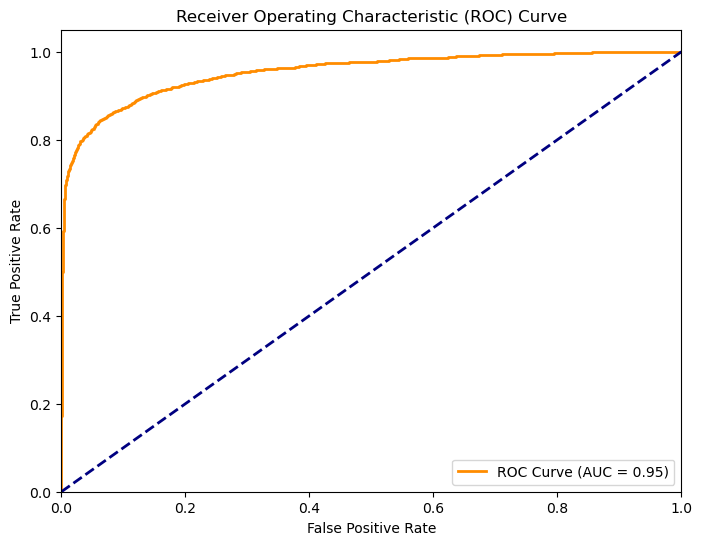

In [17]:
# 分割數據進行詳細評估
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 訓練並預測
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_val)
y_pred_proba = final_model.predict_proba(X_val)[:, 1]

# 分類報告
print("Validation Set Classification Report:")
print(classification_report(y_val, y_pred))
print("Validation Set ROC-AUC Score:", roc_auc_score(y_val, y_pred_proba))

# 繪製 ROC 曲線
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

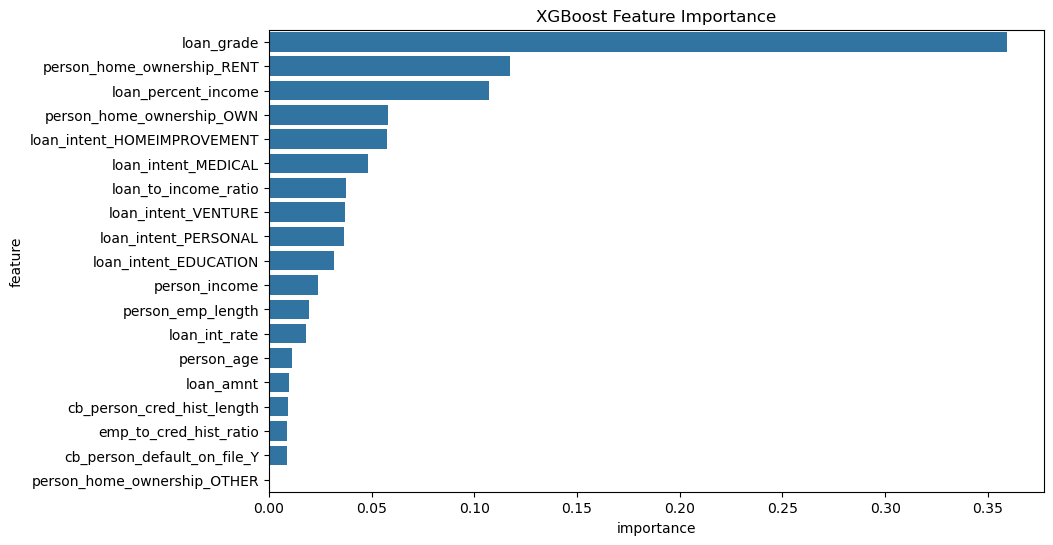

Feature Importance:
                        feature  importance
3                    loan_grade    0.359227
10   person_home_ownership_RENT    0.117498
6           loan_percent_income    0.107080
9     person_home_ownership_OWN    0.057906
12  loan_intent_HOMEIMPROVEMENT    0.057342
13          loan_intent_MEDICAL    0.048223
17         loan_to_income_ratio    0.037624
15          loan_intent_VENTURE    0.037208
14         loan_intent_PERSONAL    0.036528
11        loan_intent_EDUCATION    0.031567
1                 person_income    0.023798
2             person_emp_length    0.019375
5                 loan_int_rate    0.017898
0                    person_age    0.011464
4                     loan_amnt    0.010069
7    cb_person_cred_hist_length    0.009458
18       emp_to_cred_hist_ratio    0.008988
16  cb_person_default_on_file_Y    0.008747
8   person_home_ownership_OTHER    0.000000


In [18]:
# 獲取特徵重要性
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# 繪製特徵重要性圖
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('XGBoost Feature Importance')
plt.show()
print("Feature Importance:")
print(feature_importance)

In [19]:
# 對測試集進行預測
test_pred = final_model.predict(test_df)
test_pred_proba = final_model.predict_proba(test_df)[:, 1]

# 創建提交文件
submission = pd.DataFrame({
    'id': test_ids,
    'loan_status': test_pred
})
submission.to_csv('submission_xgb.csv', index=False)
print("Prediction Results Saved as submission_xgb.csv")

Prediction Results Saved as submission_xgb.csv


In [20]:
print("Test Set Prediction Distribution:")
print(pd.Series(test_pred).value_counts(normalize=True))

Test Set Prediction Distribution:
0    0.888639
1    0.111361
Name: proportion, dtype: float64


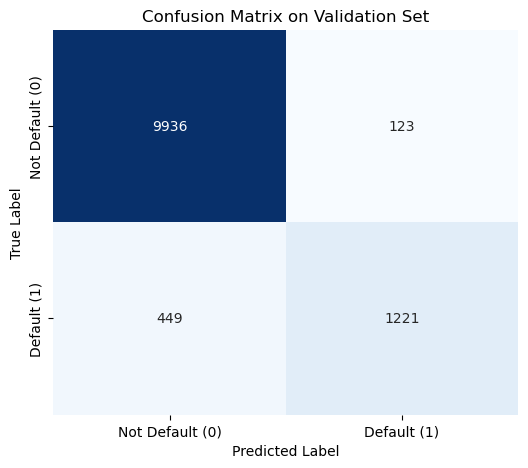

In [21]:
from sklearn.metrics import confusion_matrix

# 計算混淆矩陣
cm = confusion_matrix(y_val, y_pred)

# 繪製混淆矩陣熱力圖
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Default (0)', 'Default (1)'],
            yticklabels=['Not Default (0)', 'Default (1)'])
plt.title('Confusion Matrix on Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()